# Kanji Character Recognition
The written Japanese language has three main character systems, each with their own purpose and characters. Kanji is one of those systems, and this dataset is full of Kanji characters.

## Goal
The goal is to train a machine learning model to be able to recognize and sort these characters from an imperfect, written image. This is an extremely similar task as the previous MNIST task but more difficult as there are more characters with more complex characters.

Author: Brady Gho

Created on 7/11/2024, last editted 7/11/2024

In [ ]:
# Meta-paramaters
BATCH_SIZE=32
EPOCHS=35
LEARNING_RATE=0.01
MOMENTUM=0.9
HIDDEN_NEURONS_1=1024
HIDDEN_NEURONS_2=361
HIDDEN_NEURONS_3=49
DROPOUT = 0.4
OUTPUT_NUM = 10
LAMBDA = 0.000065 # set to zero if you don't want any L1 regularization

In [ ]:
# Loading Data

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


to_tensor = transforms.Compose({
    transforms.ToTensor()
})

# Load KMNIST dataset
train_dataset = datasets.KMNIST(root='./data', train=True,transform=to_tensor, download=True)

# Split into training and testing datasets
train_size = int(0.5 * len(train_dataset))
test_size = int(0.3 * len(train_dataset))
val_size = len(train_dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(train_dataset, [train_size, test_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 18165135/18165135 [00:09<00:00, 1833608.94it/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 374330.98it/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:01<00:00, 1654707.99it/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 6988231.85it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [ ]:
# Defining model class and evaluation model function

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class KanjiClassifier(nn.Module):
  def __init__(self, hidden_neurons_1 = HIDDEN_NEURONS_1, hidden_neurons_2 = HIDDEN_NEURONS_2, hidden_neurons_3 = HIDDEN_NEURONS_3, dropout_prob=DROPOUT):
    super(KanjiClassifier, self).__init__()
    self.flatten = nn.Flatten(start_dim=1) #starting dim 1 to not flatten batch size
    self.layer1 = nn.Linear(28*28, hidden_neurons_1)
    self.dropout1 = nn.Dropout(p=dropout_prob)
    self.layer2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
    self.dropout2 = nn.Dropout(p=dropout_prob)
    self.layer3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
    self.dropout3 = nn.Dropout(p=dropout_prob)
    self.output_layer = nn.Linear(hidden_neurons_3, OUTPUT_NUM)
    self.ReLU = nn.ReLU()
    self.Softmax = nn.Softmax(dim=1)

  def forward(self, x):
      x = self.flatten(x)
      x = self.ReLU(self.layer1(x))
      x = self.dropout1(x)
      x = self.ReLU(self.layer2(x))
      x = self.dropout2(x)
      x = self.ReLU(self.layer3(x))
      x = self.dropout3(x)
      x = self.Softmax(self.output_layer(x))
      return x

def eval_model(data_loader, model, decimals=3):
  total_correct = 0
  total_loss = 0

  model.eval()

  with torch.no_grad():
    for inputs, targets in data_loader:
      predictions = model(inputs)

      loss = loss_fn(predictions, targets)
      total_loss += loss.item()

      predicted_classes = torch.argmax(predictions, dim=1)
      correct_predictions = (predicted_classes == targets)
      correct_predictions = correct_predictions.float()
      num_correct = correct_predictions.sum()
      total_correct += num_correct

  return total_loss/len(data_loader), round(100*float(total_correct / (len(data_loader)*BATCH_SIZE)), decimals)

In [ ]:
# Training Model

KClass = KanjiClassifier()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(KClass.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

train_loss_history = []
val_accuracy_history = []
val_loss_history = []

initial_test_loss, initial_test_accuracy = eval_model(test_loader, KClass)
initial_val_loss, initial_val_accuracy = eval_model(val_loader, KClass)

val_loss_history.append(initial_val_loss)
val_accuracy_history.append(initial_val_accuracy)
print(f"Epoch 0 / {EPOCHS}: Validation loss {val_loss_history[-1]}. Validation accuracy: {val_accuracy_history[-1]}%")


for epoch in range(EPOCHS):

  KClass.train()
  for inputs, targets in train_loader:
    optimizer.zero_grad()
    predictions = KClass.forward(inputs)
    loss = loss_fn(predictions, targets)

    # L1 regularization
    L1_reg = 0
    for param in KClass.parameters():
      L1_reg += torch.sum(torch.abs(param))

    total_loss = loss + LAMBDA * L1_reg

    train_loss_history.append(loss.item())
    total_loss.backward()
    optimizer.step()

  eval_loss, eval_accuracy = eval_model(val_loader, KClass)

  val_accuracy_history.append(eval_accuracy)
  val_loss_history.append(eval_loss)

  print(f"Epoch {epoch+1} / {EPOCHS}: Validation loss {val_loss_history[-1]}. Validation accuracy: {val_accuracy_history[-1]}%")

final_test_loss, final_test_accuracy = eval_model(test_loader, KClass)

print('\n')
print(f"Initial test loss: {initial_test_loss}. Initial test accuracy: {initial_test_accuracy}%")
print(f"Final test loss: {final_test_loss}. Final test accuracy: {final_test_accuracy}%")

Epoch 0 / 35: Validation loss 2.3025706850687664. Validation accuracy: 9.683%
Epoch 1 / 35: Validation loss 2.288458299636841. Validation accuracy: 16.9%
Epoch 2 / 35: Validation loss 2.0621527620951334. Validation accuracy: 42.1%
Epoch 3 / 35: Validation loss 1.8714053087234497. Validation accuracy: 60.158%
Epoch 4 / 35: Validation loss 1.8233708874384562. Validation accuracy: 64.15%
Epoch 5 / 35: Validation loss 1.8072211062113444. Validation accuracy: 65.742%
Epoch 6 / 35: Validation loss 1.7912312857309978. Validation accuracy: 66.833%
Epoch 7 / 35: Validation loss 1.7346145254770915. Validation accuracy: 72.942%
Epoch 8 / 35: Validation loss 1.7061609805425009. Validation accuracy: 75.567%
Epoch 9 / 35: Validation loss 1.6567274297078451. Validation accuracy: 81.717%
Epoch 10 / 35: Validation loss 1.6345532185236613. Validation accuracy: 83.275%
Epoch 11 / 35: Validation loss 1.6261303335825603. Validation accuracy: 83.9%
Epoch 12 / 35: Validation loss 1.6146349929173787. Validati

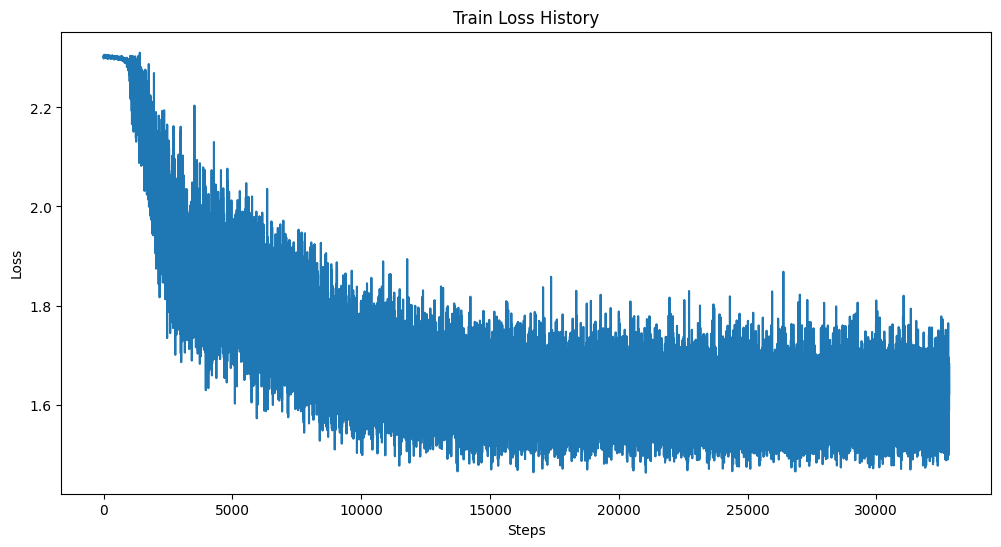

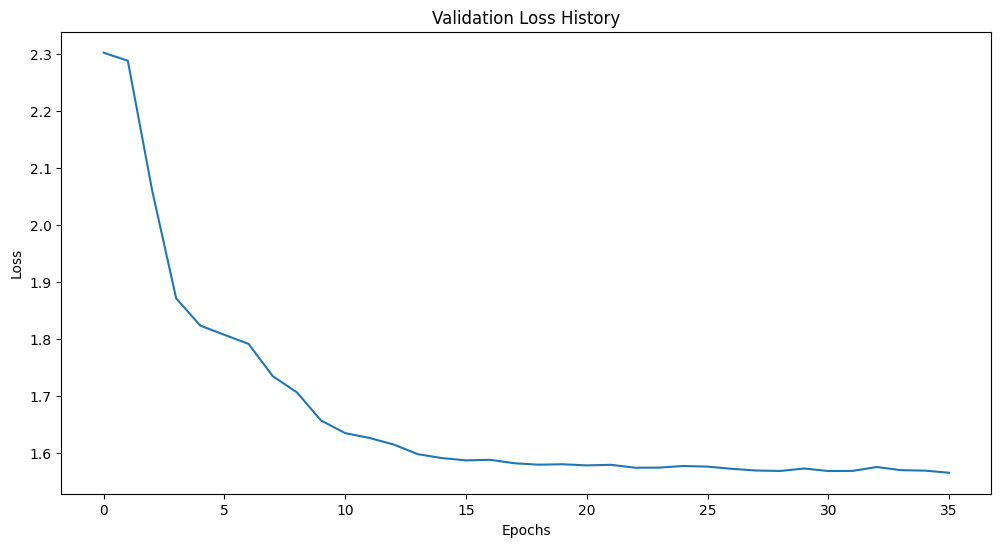

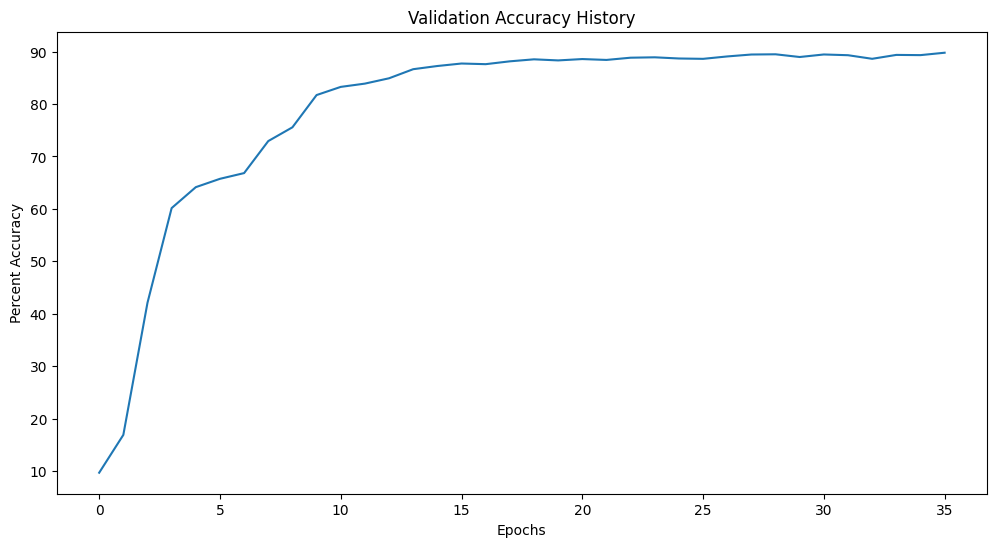

In [ ]:
# Plots

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label="Train Loss History")
plt.title("Train Loss History")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(val_loss_history, label="Validation Loss History")
plt.title("Validation Loss History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(val_accuracy_history, label="Validation Accuracy History")
plt.title("Validation Accuracy History")
plt.xlabel("Epochs")
plt.ylabel("Percent Accuracy")
plt.show()